# A testing ground for pyPIPS functionality
Testing automatic detection of deployments using time jumps, compass direction changes, and gps speed/location changes

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.polarimetric as dualpol
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as feature
from natsort import natsorted
from pprint import pprint
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [106]:
def split_dataset_by_time(ds, time_break_thresh):
    time_diff = ds['time'].diff('time', label='lower').astype(np.float)*1.e-9

    time_breaks = xr.concat([ds['time'].where(time_diff > time_break_thresh, drop=True), 
                             ds['time'][-1]], dim='time')
    print(time_breaks)

    int_indices = range(ds.sizes['time'])
    int_ind_da = xr.DataArray(int_indices, coords=[('time', ds.coords['time'].values)])
    break1_index = int_ind_da.sel(time=time_breaks[0]).item()

    ds_dlist = []
    t1 = ds['time'][0]
    deploy_num = 1
    for time in time_breaks:
        t1_datetime = t1.values.astype('datetime64[us]').astype(datetime) # This is insane just to get a datetime
        t1_stamp = t1_datetime.strftime('%Y-%m-%d: %H:%M:%S')
        t2 = time
        t2_datetime = t2.values.astype('datetime64[us]').astype(datetime)
        t2_stamp = t2_datetime.strftime('%Y-%m-%d: %H:%M:%S')
        print("Deployment #{}. Time range: {} -- {}".format(deploy_num, t1_stamp, t2_stamp))
        ds_dlist.append(ds.sel(time=slice(t1, t2)))
        deploy_num += 1
        if ~(time == time_breaks[-1]):
            next_t1_index = int_ind_da.sel(time=time) + 1
            t1 = ds['time'].isel(time=next_t1_index)
    return ds_dlist

In [107]:
PIPS_dir = '/Users/dawson29/Dropbox/PIPS_data/2016/022416/netcdf'
deployment_name = 'Test_022416'
PIPS_name = 'PIPS1A'
parsivel_interval = 10
parsivel_filename = 'parsivel_combined_{}_{}_{:d}s.nc'.format(deployment_name, PIPS_name, parsivel_interval)
parsivel_filepath = os.path.join(PIPS_dir, parsivel_filename)
conv_filename = 'conventional_raw_{}_{}.nc'.format(deployment_name, PIPS_name)
conv_filepath = os.path.join(PIPS_dir, conv_filename)
parsivel_ds = xr.load_dataset(parsivel_filepath)
conv_ds = xr.load_dataset(conv_filepath)

<xarray.DataArray 'time' (time: 2)>
array(['2016-02-24T02:36:19.000000000', '2016-02-24T23:46:15.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-02-24T02:36:19 2016-02-24T23:46:15
Deployment #1. Time range: 2016-02-24: 02:34:22 -- 2016-02-24: 02:36:19
Deployment #2. Time range: 2016-02-24: 04:10:08 -- 2016-02-24: 23:46:15
<xarray.DataArray 'time' (time: 2)>
array(['2016-02-24T02:36:10.000000000', '2016-02-24T23:46:10.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time           (time) datetime64[ns] 2016-02-24T02:36:10 2016-02-24T23:46:10
    flagged_times  (time) int64 0 0
Deployment #1. Time range: 2016-02-24: 02:35:20 -- 2016-02-24: 02:36:10
Deployment #2. Time range: 2016-02-24: 04:11:20 -- 2016-02-24: 23:46:10


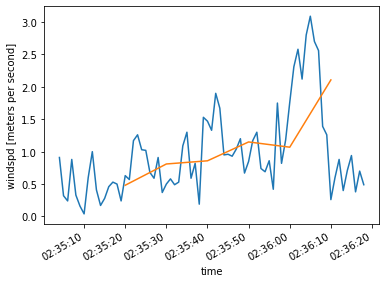

In [108]:
# Look for big time breaks in the dataset and split the dataset where these breaks occur. Then dump the new
# split datasets back out to disk
time_break_thresh = 900.

conv_ds_dlist = split_dataset_by_time(conv_ds, time_break_thresh)
conv_ds_dlist[0]['windspd'].plot()
parsivel_ds_dlist = split_dataset_by_time(parsivel_ds, time_break_thresh)
parsivel_ds_dlist[0]['windspd'].plot()

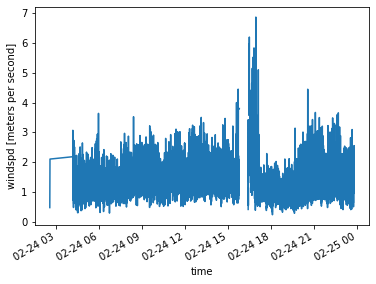

In [3]:
wind_spd_parsivel = parsivel_ds['windspd']
wind_spd_parsivel.plot()

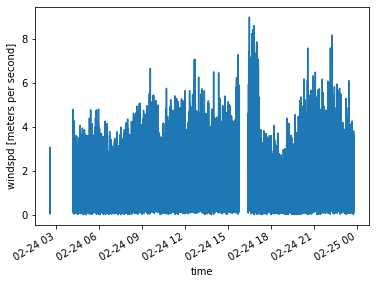

In [4]:
wind_spd_conv = conv_ds['windspd']
wind_spd_conv.plot()

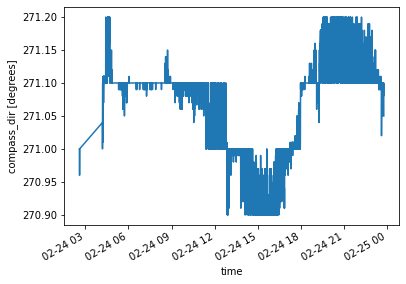

In [5]:
compass_dir_parsivel = parsivel_ds['compass_dir']
compass_dir_parsivel.plot()

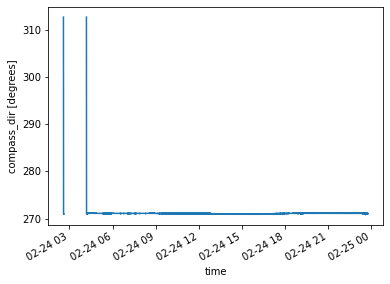

In [6]:
compass_dir_conv = conv_ds['compass_dir']
compass_dir_conv.plot()

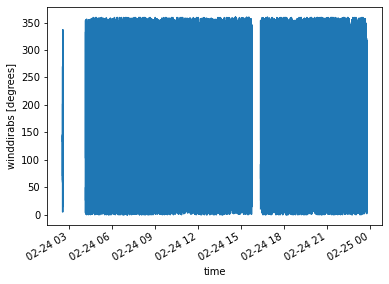

In [7]:
wind_dir_conv = conv_ds['winddirabs']
wind_dir_conv.plot()

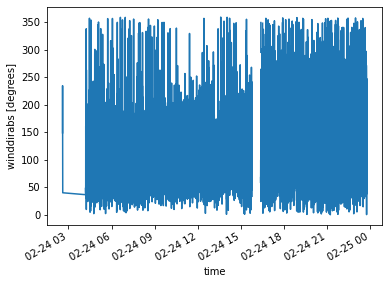

In [8]:
wind_dir_parsivel = parsivel_ds['winddirabs']
wind_dir_parsivel.plot()

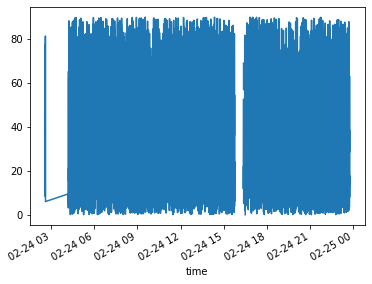

In [9]:
parsivel_angle = pips.calc_parsivel_wind_angle(wind_dir_parsivel, compass_dir_parsivel, parsivel_ds.parsivel_angle)
parsivel_angle.plot()

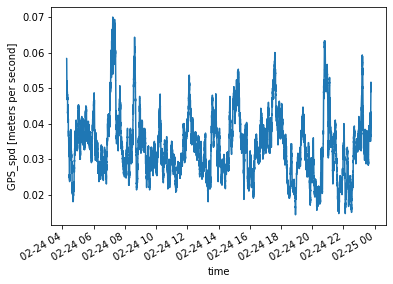

In [10]:
GPS_spd = conv_ds['GPS_spd']
GPS_rolling = GPS_spd.rolling(time=300)
GPS_rolling_mean = GPS_rolling.mean()
GPS_rolling_mean.plot()

In [36]:
conv_ds

<xarray.Dataset>
Dimensions:      (time: 70686)
Coordinates:
  * time         (time) datetime64[ns] 2016-02-24T02:34:22 ... 2016-02-24T23:...
Data variables: (12/24)
    voltage      (time) float64 0.0 0.0 0.0 0.0 0.0 ... 12.04 12.04 12.04 12.04
    winddirrel   (time) float64 nan nan nan nan nan ... 271.0 243.0 252.0 271.0
    windspd      (time) float64 nan nan nan nan nan ... 1.07 1.33 1.27 1.97 2.03
    winddiag     (time) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    fasttemp     (time) float64 4.419 4.418 4.417 4.417 ... 0.349 0.352 0.354
    slowtemp     (time) float64 -80.0 -80.0 -80.0 -80.0 ... 0.236 0.16 0.259
    ...           ...
    winddirabs   (time) float64 nan nan nan nan nan ... 182.1 154.1 163.1 182.0
    dewpoint     (time) float64 nan nan nan nan ... -0.2838 -0.3737 -0.2609
    RH_derived   (time) float64 -0.003 -0.003 -0.003 ... 95.52 94.87 95.64
    pt           (time) float64 nan nan nan nan nan ... 275.6 275.6 275.6 275.6
    qv           (time) float64 nan nan nan nan ... 0.003866 0.00384 0.003872
    rho          (time) float64 nan nan nan nan nan ... 1.237 1.237 1.237 1.237
Attributes:
    probe_name:       PIPS1A
    parsivel_angle:   -45.0
    deployment_name:  Test_022416
    location:         (40.44216684377569, -86.96749999999999, 211.71466179262...
    starting_time:    20160224023520
    ending_time:      20160224234610

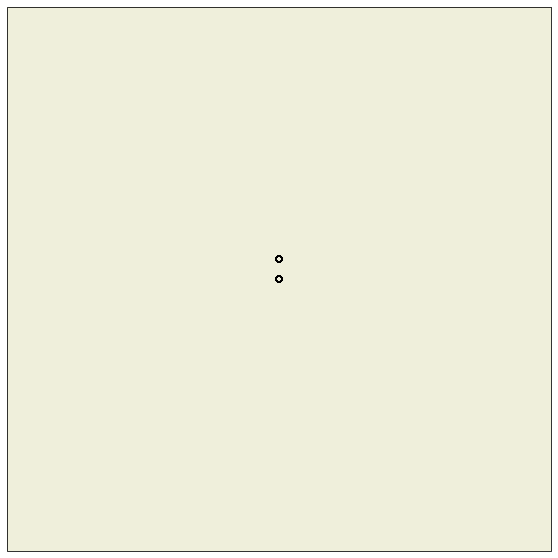

In [39]:
# Set up map
width_x = 500. # m
width_y = 500. # m

location = eval(str(conv_ds.location))
ctrlat = location[0]
ctrlon = location[1]

trulon = ctrlon
trulat1 = 35.
trulat2 = 45.
projection = ccrs.LambertConformal(ctrlon, ctrlat, false_easting=width_x/2., false_northing=width_y/2.,
                                   standard_parallels=[trulat1, trulat2])

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# ax.stock_img()
# Add coastlines and states
ax.coastlines()
land = feature.LAND
ax.add_feature(land) # , edgecolor='face', facecolor=feature.COLORS['land'])
states = feature.STATES
# states = feature.NaturalEarthFeature(category="cultural", scale="50m",
#                                      facecolor="none",
#                                      name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=1., edgecolor='k', alpha=0.5)
rivers = feature.RIVERS
ax.add_feature(rivers, linewidth=0.75, edgecolor='b', alpha=0.5)
ax.add_feature(feature.NaturalEarthFeature('cultural', 'roads', '10m'), facecolor='none', edgecolor='b')
# # Add counties if desired. TODO: add back more features here after testing

# # if runname == pc.runname_list[0] and time == time_list[0]:

# print("Reading counties from shapefile")
county_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/county/countyp020'
counties = plotmod.read_shapefile(county_shapefile_location)
ax.add_feature(counties, linewidth=0.5, edgecolor='grey', alpha=0.5)

# Add urban areas
# urban_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/urban2/tl_2008_us_cbsa'
# urban = plotmod.read_shapefile(urban_shapefile_location)
# ax.add_feature(urban, linewidth=0.5, facecolor='purple', edgecolor='none', alpha=0.25)

# Add more stuff from GADM database (EDIT: doesn't seem to add anything beyond counties)
# gadm_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/gadm/gadm36_USA_2'
# gadm_shapes = plotmod.read_shapefile(gadm_shapefile_location)
# ax.add_feature(gadm_shapes, linewidth=0.5, edgecolor='purple', alpha=0.8)

ax.set_xlim(0., width_x)
ax.set_ylim(0., width_y)
ax.scatter([ctrlon], [ctrlat], color='black', marker='o', facecolor='none', transform=ccrs.PlateCarree())

lons = conv_ds['GPS_lon']
lats = conv_ds['GPS_lat']
ax.scatter(lons, lats, color='black', marker='o', facecolor='none', alpha=0.75, transform=ccrs.PlateCarree())

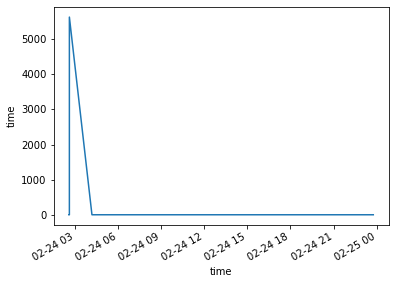

<xarray.DataArray 'time' (time: 2)>
array(['2016-02-24T02:36:19.000000000', '2016-02-24T23:46:15.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-02-24T02:36:19 2016-02-24T23:46:15
Deployment #1. Time range: 2016-02-24: 02:34:22 -- 2016-02-24: 02:36:19
Deployment #2. Time range: 2016-02-24: 04:10:08 -- 2016-02-24: 23:46:15


<xarray.Dataset>
Dimensions:      (time: 70568)
Coordinates:
  * time         (time) datetime64[ns] 2016-02-24T04:10:08 ... 2016-02-24T23:...
Data variables: (12/24)
    voltage      (time) float64 0.0 0.0 0.0 0.0 0.0 ... 12.04 12.04 12.04 12.04
    winddirrel   (time) float64 nan nan nan nan nan ... 271.0 243.0 252.0 271.0
    windspd      (time) float64 nan nan nan nan nan ... 1.07 1.33 1.27 1.97 2.03
    winddiag     (time) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    fasttemp     (time) float64 3.429 3.429 3.43 3.431 ... 0.349 0.352 0.354
    slowtemp     (time) float64 -80.0 -80.0 -80.0 -80.0 ... 0.236 0.16 0.259
    ...           ...
    winddirabs   (time) float64 nan nan nan nan nan ... 182.1 154.1 163.1 182.0
    dewpoint     (time) float64 nan nan nan nan ... -0.2838 -0.3737 -0.2609
    RH_derived   (time) float64 -0.003 -0.003 -0.003 ... 95.52 94.87 95.64
    pt           (time) float64 nan nan nan nan nan ... 275.6 275.6 275.6 275.6
    qv           (time) float64 nan nan nan nan ... 0.003866 0.00384 0.003872
    rho          (time) float64 nan nan nan nan nan ... 1.237 1.237 1.237 1.237
Attributes:
    probe_name:       PIPS1A
    parsivel_angle:   -45.0
    deployment_name:  Test_022416
    location:         (40.44216684377569, -86.96749999999999, 211.71466179262...
    starting_time:    20160224023520
    ending_time:      20160224234610

In [76]:
print(wind_dir_conv.coords['time'])
print(len(wind_dir_conv.time))
print(len(np.unique(wind_dir_conv.time.data)))
unique_times = np.unique(wind_dir_conv['time'])
print(unique_times)
duplicated = wind_dir_conv.indexes['time'].duplicated()
print(duplicated)
dup_indices = np.where(duplicated)[0]
print(dup_indices)
#duplicated = xr.DataArray(parsivel_ds_read.indexes['time'].duplicated())
duplicated_times = wind_dir_conv['time'].isel(time=dup_indices)
print(duplicated_times)
duplicated_times_only = wind_dir_conv.isel(time=dup_indices)
print(duplicated_times_only)

<xarray.DataArray 'time' (time: 70686)>
array(['2016-02-24T02:34:22.000000000', '2016-02-24T02:34:23.000000000',
       '2016-02-24T02:34:24.000000000', ..., '2016-02-24T23:46:13.000000000',
       '2016-02-24T23:46:14.000000000', '2016-02-24T23:46:15.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-02-24T02:34:22 ... 2016-02-24T23:46:15
70686
70686
['2016-02-24T02:34:22.000000000' '2016-02-24T02:34:23.000000000'
 '2016-02-24T02:34:24.000000000' ... '2016-02-24T23:46:13.000000000'
 '2016-02-24T23:46:14.000000000' '2016-02-24T23:46:15.000000000']
[False False False ... False False False]
[]
<xarray.DataArray 'time' (time: 0)>
array([], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 
<xarray.DataArray 'winddirabs' (time: 0)>
array([], dtype=float64)
Coordinates:
  * time     (time) datetime64[ns] 
Attributes:
    units:    degrees


In [ ]:
time_diff = wind_spd_conv['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)

In [ ]:
int_indices = range(wind_spd_conv.sizes['time'])
print(wind_spd_conv.coords['time'].values)
int_ind_da = xr.DataArray(int_indices, coords=[('time', wind_spd_conv.coords['time'].values)])
print(int_ind_da)

In [ ]:
print(int_ind_da.sel(time='2017-04-30T20:40:18.000000000'))

In [ ]:
print(wind_spd_conv.isel(time=74415))
print(wind_spd_conv.isel(time=74416))
print(wind_spd_conv.isel(time=74417))
print(wind_spd_conv.isel(time=74418))

In [ ]:
time_diff = parsivel_ds['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)

In [ ]:
PIPS_dir2 = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_new_test/'
parsivel_filepath2 = os.path.join(PIPS_dir, 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s.nc')
conv_filepath2 = os.path.join(PIPS_dir, 'conventional_raw_FMCW_2017_043017_PIPS2A.nc')
parsivel_ds2 = xr.load_dataset(parsivel_filepath2)
conv_ds2 = xr.load_dataset(conv_filepath2)

In [ ]:
time_diff = parsivel_ds2['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)